# U2NET - split - self

In [2]:
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
import sys
import argparse
# import torch.optim as optim

import numpy as np
import os
from PIL import Image
import glob
from matplotlib import pyplot as plt
# sys.path.append("../Models")
# sys.path.append("../Models/DeepSegmentor")
from U2NET.dataloader import Rescale
from U2NET.dataloader import ToTensor
from U2NET.dataloader import CrackDataset
from U2NET.u2net import U2NET

import cv2
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchmetrics

from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score,  average_precision_score, roc_auc_score, mean_absolute_error

# PREREQUISITES

In [2]:
model_dir = "u2net_deepcrack_fromscratch_focal_bce_itr_7000_train_1.233383_tar_0.169936.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
plot_dir = "plotted_output"
#dataset directory

dataset_dir = "DeepCrack/dataset/"
# train_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Datasets/deepcrack/train/"
prediction_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/Plotted_output/final/u2net_self_dc"

test_dataset = CrackDataset(
    img_path = dataset_dir + 'images/',
    mask_path = dataset_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
train_dataset = CrackDataset(
    img_path = train_dir + 'images/',
    mask_path = train_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
test_dataloader = DataLoader(test_dataset,
                                    batch_size=6,
                                    shuffle=False,
                                    num_workers=6)
train_dataloader = DataLoader(train_dataset,
                                    batch_size=6,
                                    shuffle=False,
                                    num_workers=6)

In [3]:
model = U2NET()
model.load_state_dict(torch.load(model_dir))
model.cuda()
model.eval()

gt_list = []
output_list = []
gt_arr = np.ndarray([])
output_arr = np.ndarray([])

bce_loss = nn.BCELoss(size_average=True)

/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    gt = data_test['rawimg']
    print(inputs_test.shape[0], "input size")
    print(gt.shape, "gt size")
    if i_test == 0:
        break

6 input size
torch.Size([6, 288, 288, 3]) gt size


## EVALUATING ON TEST

In [17]:
gt_arr = np.ndarray([])
len = 0
output_arr = np.ndarray([])
for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output, a,b,c,d,e = model(inputs_test)
    gt = data_test['mask']
    print(gt.shape)
    print(inputs_test.shape)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)
    len +=int(inputs_test.shape[0])

#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (-1,288,288))
    gt_arr = np.append(gt_np, gt_arr)
    output_np = np.reshape((output.cpu()).data.numpy(), (-1,288,288))
#    output_list.append(output_np)
    output_arr = np.append(output_np, output_arr)
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
#     fig, axes = plt.subplots(1, 2, figsize = (12, 4))
#     axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[0].set_title('Ground Truth')
#     axes[0].axis('off')
#     axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[1].set_title(str(os.path.basename(model_dir)))
#     axes[1].axis('off')
#     axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
#     plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
#     plt.close()
    del output, a,b,c,d,e, loss1
print(len)
assert gt_arr.shape == output_arr.shape
print(int(gt_arr.shape[0]), "  ", 288*288*len)
assert int(gt_arr.shape[0]) == 288*288*len +1

/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.3984518e-15 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.0755295e-13 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.6762576e-11 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  4.3612505e-12 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  7.286081e-15 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.3168235e-14 :min of ops
torch.Size([6, 1, 288, 288])
torch.Size([6, 3, 288, 288])
1.0 :max of ground truth  0.0 :

In [5]:
# Assuming bce_loss is defined elsewhere in your code
gt_arr = np.ndarray([])
len = 0
output_arr = np.ndarray([])

for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    raw_images = data_test['rawimg']

    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    
    output, a, b, c, d, e = model(inputs_test)
    gt = data_test['mask']
    
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)
    
    len += int(inputs_test.shape[0])

    # Outputs and ground truth
    img_np = (inputs_test.cpu()).data.numpy().transpose((0, 2, 3, 1))
    gt_np = np.reshape((gt.cpu()).data.numpy(), (-1, 288, 288))
    gt_arr = np.append(gt_np, gt_arr)
    output_np = np.reshape((output.cpu()).data.numpy(), (-1, 288, 288))
    output_arr = np.append(output_np, output_arr)

    loss1 = bce_loss(output, gt)

    # Create a subplot for each image in the batch
    fig, axes = plt.subplots(6, 3, figsize=(12, 4 * 6))
    for j in range(inputs_test.shape[0]):
        # Convert the input image to uint8 for visualization
#         input_test_single = cv2.cvtColor((img_np[j] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        input_test_single = raw_images[j]

        gt_np_single = gt_np[j]
        output_np_single = output_np[j]

        # Calculate subplot indices
        axes[j, 0].imshow(input_test_single)  # Use cmap='viridis' for RGB images
        axes[j, 0].axis('off')
        
        axes[j, 1].imshow(gt_np_single, cmap='gray', vmin=0, vmax=1)
        axes[j, 1].axis('off')

        axes[j, 2].imshow(output_np_single, cmap='gray', vmin=0, vmax=1)
        axes[j, 2].axis('off')

    plt.tight_layout()
    plt.savefig(prediction_dir + os.sep + str(i_test) + '.png', dpi=300, bbox_inches='tight')
    plt.close()

print(len)
assert gt_arr.shape == output_arr.shape
print(int(gt_arr.shape[0]), "  ", 288 * 288 * len)
assert int(gt_arr.shape[0]) == 288 * 288 * len + 1


/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


237
19657729    19657728


## FSCORE NIKALO

In [22]:
gt_arr = gt_arr.astype(np.uint8)
precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)

# # F1 = f1_score(gt_arr, output_arr, pos_label=1)
# # best_threshold = thresholds[np.argmax(f1_score)]
# # print(f"best threshold {best_threshold} best f1 score : {np.max(f1_scores)}")
threshold_range = np.linspace(0.8, 1, 20)
f1_scores_2 = []
js_list = []
for t in threshold_range:
    output_binary = np.where(output_arr >= t, 1, 0)
    js = sklearn.metrics.jaccard_score(gt_arr, output_binary, average='macro')
    f1 = f1_score(gt_arr, output_binary, pos_label=1)
    print(t,":",f1, "  ",js)
    f1_scores_2.append(f1)
    js_list.append(js)
print(f"F1 score from sklearn {max(f1_scores_2)}, max corresponding threshold is {threshold_range[np.argmax(f1_scores_2)]}")


0.8 : 0.7525220863317226    0.7933625033732712
0.8105263157894738 : 0.752821666010268    0.7935790190861214
0.8210526315789474 : 0.7531384100604818    0.7938079578725243
0.8315789473684211 : 0.7534819029059076    0.7940557615463517
0.8421052631578948 : 0.7539018271779131    0.794356590352403
0.8526315789473684 : 0.7542364790493812    0.7946006334639928
0.8631578947368421 : 0.7546796782943591    0.7949196836684715
0.8736842105263158 : 0.7550932880931336    0.795220249698176
0.8842105263157896 : 0.7554949313327339    0.7955147475993547
0.8947368421052632 : 0.7559712338038679    0.7958615766535928
0.9052631578947369 : 0.7565707649449361    0.7962953601523468
0.9157894736842105 : 0.7571714920797509    0.7967329592356889
0.9263157894736842 : 0.7578248500809751    0.7972110185589774
0.9368421052631579 : 0.7585760570225174    0.7977602989777416
0.9473684210526316 : 0.7593787148820159    0.7983537869897954
0.9578947368421052 : 0.7602712293959877    0.7990191716169183
0.968421052631579 : 0.7614

## PR CURVE

1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  2.4768126e-12 :min of ops
(19657729,)
(19657729,)
Average Precision Score: 0.8376010038547886
ROC AUC Score: 0.9736218719940611
MAE Score: 0.017358280432361723
Precision Score: [0.02940541 0.02940536 0.02940536 ... 0.97449638 0.97940976 1.        ]
Recall Score: [1.         0.99999827 0.99999827 ... 0.26520575 0.22827219 0.        ]
Mean IoU (Jaccard Score): 0.6179534343587652
Accuracy Score: 0.9860424365398465
Class-wise Accuracy:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  19079691
           1       0.76      0.77      0.76    578038

    accuracy                           0.99  19657729
   macro avg       0.88      0.88      0.88  19657729
weighted avg       0.99      0.99      0.99  19657729



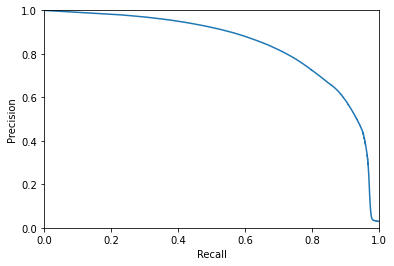

In [21]:
import sklearn
gt_arr = gt_arr.astype(np.uint8)
print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")
print(gt_arr.shape)
print(output_arr.shape)


precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
output_binary = np.where(output_arr >= 0.98888888, 1, 0)
precison_score = sklearn.metrics.precision_score(gt_arr, output_binary)
recall_score = sklearn.metrics.recall_score(gt_arr, output_binary)
miou = sklearn.metrics.jaccard_score(gt_arr, output_binary)
accuracy = sklearn.metrics.accuracy_score(gt_arr, output_binary)
class_wise_accuracy = sklearn.metrics.classification_report(gt_arr, output_binary)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Mean IoU (Jaccard Score): {miou}")
print(f"Accuracy Score: {accuracy}")
print(f"Class-wise Accuracy:\n{class_wise_accuracy}")
plt.xlim(left=0.0)
plt.ylim(ymin=0)
plt.plot(recall,precision)
# plt.title('Precision-Recall Curve\n'
#           f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
# #           f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
# #           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
#          )
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0, 1)
plt.savefig(plot_dir+os.sep+'pr_curve_normal.png')
plt.show()

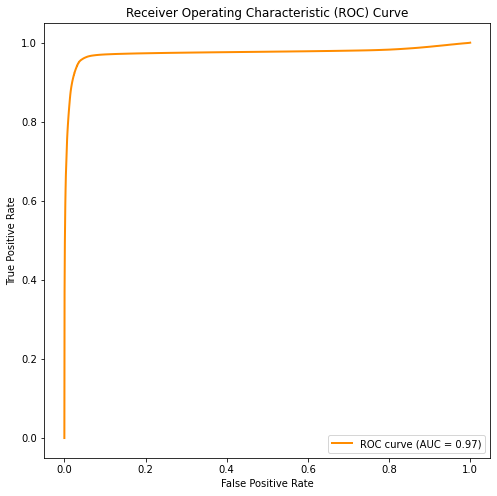

In [28]:
fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(gt_arr, output_arr)
roc_auc = roc_auc_score(gt_arr, output_arr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(plot_dir+os.sep+'roc_auc_normal.png')
plt.show()

In [24]:
np.save('/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/arrays/u2net_self_dc/output_array_normal.npy', output_arr)
np.save('/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/arrays/u2net_self_dc/output_binary_normal.npy', output_binary)

## PR CURVE INVERTED

Average Precision Score: 0.9981235189241625
ROC AUC Score: 0.9736218719940606
MAE Score: 0.017358280432361723


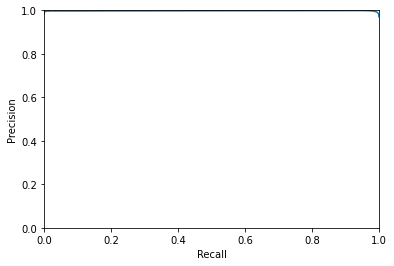

In [23]:
gt_arr_inverted = np.logical_not(gt_arr)
output_arr_inverted = 1 - output_arr
ap_score = average_precision_score(gt_arr_inverted, output_arr_inverted)
roc_auc_score1 = roc_auc_score(gt_arr_inverted, output_arr_inverted)
mae_score = mean_absolute_error(gt_arr_inverted, output_arr_inverted)
precision, recall, thresholds = precision_recall_curve(gt_arr_inverted, output_arr_inverted, pos_label=1)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
# plt.title('Precision-Recall Curve\n'
#           f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
#         #   f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
# #           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
#          )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0, 1)
plt.savefig(plot_dir+os.sep+'pr_curve_inverted.png')
plt.show()

In [10]:
threshold_range = np.linspace(0, 1, 100)
f1_scores_2 = []

for t in threshold_range:
    output_binary = np.where(output_arr_inverted >= t, 1, 0)

    f1 = f1_score(gt_arr_inverted, output_binary, pos_label=1)
    print(t,":",f1)
    f1_scores_2.append(f1)

print(f"F1 score from sklearn {max(f1_scores_2)}, max corresponding threshold is {threshold_range[np.argmax(f1_scores_2)]}")


0.0 : 0.9850780459824118
0.010101010101010102 : 0.9928355511891007
0.020202020202020204 : 0.992612001857235
0.030303030303030304 : 0.9924621646036375
0.04040404040404041 : 0.9923493396305257
0.05050505050505051 : 0.9922633054781806
0.06060606060606061 : 0.9921894585353849
0.07070707070707072 : 0.9921259974868009
0.08080808080808081 : 0.9920714893727004
0.09090909090909091 : 0.9920209274745476
0.10101010101010102 : 0.9919756569952509
0.11111111111111112 : 0.9919347123614064
0.12121212121212122 : 0.991898709642869
0.13131313131313133 : 0.9918653003523392
0.14141414141414144 : 0.9918327793906406
0.15151515151515152 : 0.9918018318168069
0.16161616161616163 : 0.9917743138913745
0.17171717171717174 : 0.9917448170202529
0.18181818181818182 : 0.9917182456404248
0.19191919191919193 : 0.9916952301552623
0.20202020202020204 : 0.991671577832407
0.21212121212121213 : 0.9916501441475313
0.22222222222222224 : 0.9916269434335077
0.23232323232323235 : 0.9916042402960653
0.24242424242424243 : 0.99158170

In [53]:
print("Unique values in gt_arr:", np.unique(gt_arr))
print(gt_arr.shape)
gt_arr = gt_arr.astype(np.uint8)
print("Unique values in gt_arr:", np.unique(gt_arr))

Unique values in gt_arr: [0.         0.06666667 0.06692913 0.13333334 0.13385826 0.13725491
 0.13779527 0.85882354 0.86220473 0.9254902  0.92913383 0.92941177
 0.93307084 0.99215686 0.99606299 0.99607843 1.        ]
(24883201,)
Unique values in gt_arr: [0 1]


## TRAIN PE PERFORMANCE

In [11]:
gt_arr = np.ndarray([])
len = 0
output_arr = np.ndarray([])
for i_test, data_test in enumerate(train_dataloader):
    print(len)
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output, a,b,c,d,e = model(inputs_test)
    gt = data_test['mask']
    print(gt.shape)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)        
    len +=int(inputs_test.shape[0])
#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (-1,288,288))
    gt_arr = np.append(gt_np, gt_arr)
    output_np = np.reshape((output.cpu()).data.numpy(), (-1,288,288))
#    output_list.append(output_np)
    output_arr = np.append(output_np, output_arr)
    if np.max(gt_np)>1:
        break
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
#     fig, axes = plt.subplots(1, 2, figsize = (12, 4))
#     axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[0].set_title('Ground Truth')
#     axes[0].axis('off')
#     axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[1].set_title(str(os.path.basename(model_dir)))
#     axes[1].axis('off')
#     axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
#     plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
#     plt.close()
    del output, a,b,c,d,e, loss1
print(len)
assert gt_arr.shape == output_arr.shape
print(int(gt_arr.shape[0]), "  ", 288*288*len)
assert int(gt_arr.shape[0]) == 288*288*len +1
        


0
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.9229695e-13 :min of ops


/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


6
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  1.4563791e-12 :min of ops
12
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  8.600146e-15 :min of ops
18
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  1.1731303e-15 :min of ops
24
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  9.667518e-16 :min of ops
30
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  3.6976914e-15 :min of ops
36
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  1.8092401e-15 :min of ops
42
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  4.8944946e-13 :min of ops
48
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  9.9817455e-12 :min of

1 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  1.1651426e-15 :min of ops
(24883201,)
(24883201,)
gt_arr shape: (24883201,)
output_arr shape: (24883201,)
Unique values in gt_arr: [0 1]
Unique values in output_arr: [4.94065646e-324 2.62002092e-019 3.09879642e-019 ... 9.99999762e-001
 9.99999881e-001 1.00000000e+000]
Average Precision Score: 0.9791286888748072
ROC AUC Score: 0.9996228187915801
MAE Score: 0.011873839895943724


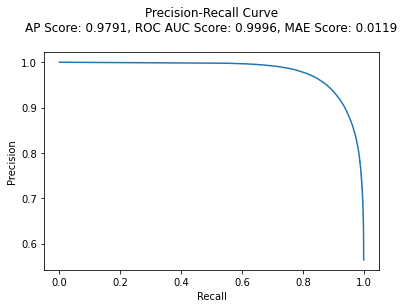

In [12]:
gt_arr = gt_arr.astype(np.uint8)
print(np.max(gt_arr), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")
print(gt_arr.shape)
print(output_arr.shape)
print("gt_arr shape:", gt_arr.shape)
print("output_arr shape:", output_arr.shape)
print("Unique values in gt_arr:", np.unique(gt_arr))
print("Unique values in output_arr:", np.unique(output_arr))


precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
#           f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
#           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
         )
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.savefig(plot_dir+os.sep+'pr_curve_final.png')
plt.show()

Average Precision Score: 0.9999935640807214
ROC AUC Score: 0.9996426378775667
MAE Score: 0.011372384908627544


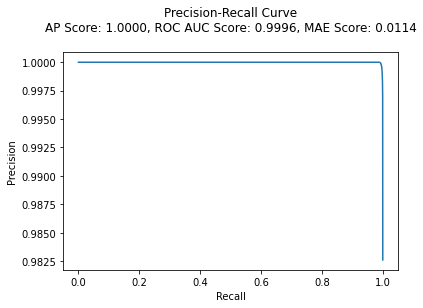

In [73]:
gt_arr_inverted = np.logical_not(gt_arr)
output_arr_inverted = 1 - output_arr
gt_arr_inverted.astype(np.uint8)
ap_score = average_precision_score(gt_arr_inverted, output_arr_inverted)
roc_auc_score1 = roc_auc_score(gt_arr_inverted, output_arr_inverted)
mae_score = mean_absolute_error(gt_arr_inverted, output_arr_inverted)
precision, recall, thresholds = precision_recall_curve(gt_arr_inverted, output_arr_inverted, pos_label=1)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
        #   f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
#           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
         )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
print(gt_arr.shape, gt_list[0].shape)
ap_scores = []
f1_scores = []

for idx in range(len(gt_list)):
    gt_list[idx] = gt_list[idx].flatten()
    output_list[idx] = output_list[idx].flatten()
    gt_list[idx] = gt_list[idx].astype(np.uint8)
    print(gt_list[idx])
    p, r, thresh = precision_recall_curve(gt_list[idx], output_list[idx], pos_label=1)
    threshold_range = np.linspace(0, 1, 50)
    f1_scores_2 = []
    for t in threshold_range:
        output_binary = np.where(output_list[idx] >= t, 1, 0)
        f1 = f1_score(gt_list[idx], output_binary, pos_label=1)
        f1_scores_2.append(f1)


    # print(f"F1 score from sklearn {F1}")


        ap_score = average_precision_score(gt_list[idx], output_list[idx])
        roc_auc_score1 = roc_auc_score(gt_list[idx], output_list[idx])
        mae_score = mean_absolute_error(gt_list[idx], output_list[idx])
        plt.plot(r,p)
        plt.title('Precision-Recall Curve\n'
            f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
            f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
            f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.savefig(plot_dir+os.sep+f'{idx}.png')
        plt.clf()

## U2NET ORIGINAL

In [2]:
from u2net import U2NET

model_dir = "/home/uas-dtu/Documents/U-2-Net-master/saved_models/deepcrack/u2net_bce_itr_18000_train_0.130911_tar_0.006513.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
plot_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/infered_plots/final/u2net_og_dc"
#dataset directory

dataset_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Datasets/deepcrack/val/"
train_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Datasets/deepcrack/train/"
prediction_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/Plotted_output/final/u2net_og_dc"

test_dataset = CrackDataset(
    img_path = dataset_dir + 'images/',
    mask_path = dataset_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
train_dataset = CrackDataset(
    img_path = train_dir + 'images/',
    mask_path = train_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
test_dataloader = DataLoader(test_dataset,
                                    batch_size=6,
                                    shuffle=False,
                                    num_workers=1)
train_dataloader = DataLoader(train_dataset,
                                    batch_size=6,
                                    shuffle=False,
                                    num_workers=1)

In [3]:
model = U2NET(3, 1)
model.load_state_dict(torch.load(model_dir))
model.cuda()
model.eval()

gt_list = []
output_list = []
gt_arr = np.ndarray([])
output_arr = np.ndarray([])

bce_loss = nn.BCELoss(size_average=True)

/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## outputs

In [11]:
gt_arr = np.ndarray([])
len = 0
output_arr = np.ndarray([])
for i_test, data_test in enumerate(test_dataloader):
    print(len)
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output, a,b,c,d,e,f = model(inputs_test)
    gt = data_test['mask']
    print(gt.shape)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)        
    len +=int(inputs_test.shape[0])
#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (-1,288,288))
    gt_arr = np.append(gt_np, gt_arr)
    output_np = np.reshape((output.cpu()).data.numpy(), (-1,288,288))
#    output_list.append(output_np)
    output_arr = np.append(output_np, output_arr)
    if np.max(gt_np)>1:
        break
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
#     fig, axes = plt.subplots(1, 2, figsize = (12, 4))
#     axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[0].set_title('Ground Truth')
#     axes[0].axis('off')
#     axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
#     axes[1].set_title(str(os.path.basename(model_dir)))
#     axes[1].axis('off')
#     axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
#     plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
#     plt.close()
    del output, a,b,c,d,e, loss1, f
print(len)
assert gt_arr.shape == output_arr.shape
print(int(gt_arr.shape[0]), "  ", 288*288*len)
assert int(gt_arr.shape[0]) == 288*288*len +1
  

0
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.99985826 :max of ops  0.0 :min of ops


/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


6
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.99989736 :max of ops  0.0 :min of ops
12
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.9999784 :max of ops  0.0 :min of ops
18
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.9999864 :max of ops  0.0 :min of ops
24
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.99998283 :max of ops  0.0 :min of ops
30
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.9999957 :max of ops  0.0 :min of ops
36
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.9999993 :max of ops  0.0 :min of ops
42
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.99999905 :max of ops  0.0 :min of ops
48
torch.Size([6, 1, 288, 288])
1.0 :max of ground truth  0.0 :min of ground truth
0.9999658 :max of ops  0.0 :min of ops
54
torch.Size([6, 1, 2

In [5]:
# Assuming bce_loss is defined elsewhere in your code
gt_arr = np.ndarray([])
len = 0
output_arr = np.ndarray([])

for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    raw_images = data_test['rawimg']

    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    
    output, a, b, c, d, e, f = model(inputs_test)
    gt = data_test['mask']
    
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)
    
    len += int(inputs_test.shape[0])

    # Outputs and ground truth
    img_np = (inputs_test.cpu()).data.numpy().transpose((0, 2, 3, 1))
    gt_np = np.reshape((gt.cpu()).data.numpy(), (-1, 288, 288))
    gt_arr = np.append(gt_np, gt_arr)
    output_np = np.reshape((output.cpu()).data.numpy(), (-1, 288, 288))
    output_arr = np.append(output_np, output_arr)

    loss1 = bce_loss(output, gt)

    # Create a subplot for each image in the batch
    fig, axes = plt.subplots(6, 3, figsize=(12, 4 * 6))
    for j in range(inputs_test.shape[0]):
        # Convert the input image to uint8 for visualization
#         input_test_single = cv2.cvtColor((img_np[j] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        input_test_single = raw_images[j]

        gt_np_single = gt_np[j]
        output_np_single = output_np[j]

        # Calculate subplot indices
        axes[j, 0].imshow(input_test_single)  # Use cmap='viridis' for RGB images
        axes[j, 0].axis('off')
        
        axes[j, 1].imshow(gt_np_single, cmap='gray', vmin=0, vmax=1)
        axes[j, 1].axis('off')

        axes[j, 2].imshow(output_np_single, cmap='gray', vmin=0, vmax=1)
        axes[j, 2].axis('off')

    plt.tight_layout()
    plt.savefig(prediction_dir + os.sep + str(i_test) + '.png', dpi=300, bbox_inches='tight')
    plt.close()

print(len)
assert gt_arr.shape == output_arr.shape
print(int(gt_arr.shape[0]), "  ", 288 * 288 * len)
assert int(gt_arr.shape[0]) == 288 * 288 * len + 1


237
19657729    19657728


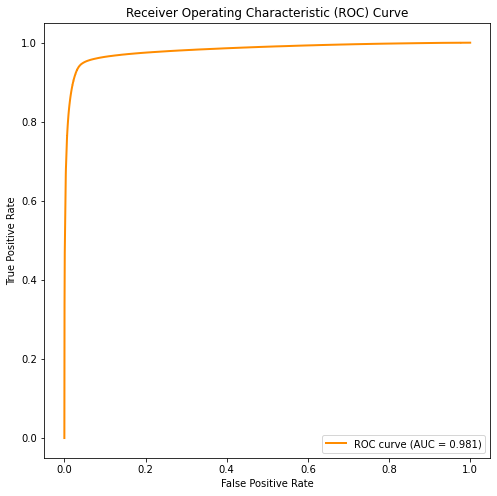

In [7]:
fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(gt_arr, output_arr)
roc_auc = roc_auc_score(gt_arr, output_arr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(plot_dir+os.sep+'roc_auc_normal.png')
plt.show()

In [9]:
gt_arr = gt_arr.astype(np.uint8)
precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)

# # F1 = f1_score(gt_arr, output_arr, pos_label=1)
# # best_threshold = thresholds[np.argmax(f1_score)]
# # print(f"best threshold {best_threshold} best f1 score : {np.max(f1_scores)}")
threshold_range = np.linspace(0.8, 1, 20)
f1_scores_2 = []
js_list = []
for t in threshold_range:
    output_binary = np.where(output_arr >= t, 1, 0)
    js = sklearn.metrics.jaccard_score(gt_arr, output_binary, average='macro')
    f1 = f1_score(gt_arr, output_binary, pos_label=1)
    print(t,":",f1, "  ",js)
    f1_scores_2.append(f1)
    js_list.append(js)
print(f"F1 score from sklearn {max(f1_scores_2)}, max corresponding threshold is {threshold_range[np.argmax(f1_scores_2)]}")


0.8 : 0.7605444734237239    0.7990705574459694
0.8105263157894738 : 0.7611577737858264    0.7995136297956834
0.8210526315789474 : 0.7617588065739734    0.7999492685437594
0.8315789473684211 : 0.7622691479822818    0.8003242278385521
0.8421052631578948 : 0.7629535489091124    0.8008204827812992
0.8526315789473684 : 0.7636283384773409    0.8013123674282367
0.8631578947368421 : 0.7643277787525546    0.801823305907251
0.8736842105263158 : 0.7649259349339264    0.8022663234639774
0.8842105263157896 : 0.7655813427787374    0.8027513118359388
0.8947368421052632 : 0.7662806449619239    0.8032691744418066
0.9052631578947369 : 0.7669236446935198    0.8037518293189488
0.9157894736842105 : 0.7675586979812693    0.804234972038772
0.9263157894736842 : 0.7681145977904493    0.8046696989353956
0.9368421052631579 : 0.7687374543208605    0.8051573692084204
0.9473684210526316 : 0.769160293973746    0.8055163926851397
0.9578947368421052 : 0.7691907468883303    0.8056180507922401
0.968421052631579 : 0.7685

1.0 :max of ground truth  0.0 :min of ground truth
1.0 :max of ops  0.0 :min of ops
(19657729,)
(19657729,)
Average Precision Score: 0.8365243217729772
ROC AUC Score: 0.981330121141456
MAE Score: 0.017470352643335765
Precision Score: [0.02940513 0.02969695 0.02969695 ... 0.98136563 0.98587813 1.        ]
Recall Score: [1.         0.99992907 0.99992907 ... 0.12782551 0.08744062 0.        ]
Mean IoU (Jaccard Score): 0.6125816592987966
Accuracy Score: 0.9869733172127869
Class-wise Accuracy:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99  19079691
           1       0.83      0.70      0.76    578038

    accuracy                           0.99  19657729
   macro avg       0.91      0.85      0.88  19657729
weighted avg       0.99      0.99      0.99  19657729



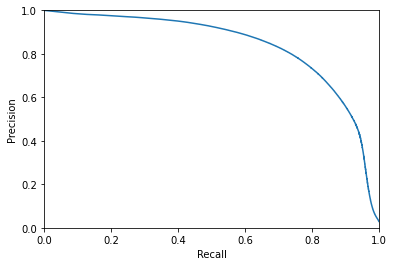

In [6]:
import sklearn
gt_arr = gt_arr.astype(np.uint8)
print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")
print(gt_arr.shape)
print(output_arr.shape)


precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
output_binary = np.where(output_arr >= 0.98888888, 1, 0)
precison_score = sklearn.metrics.precision_score(gt_arr, output_binary)
recall_score = sklearn.metrics.recall_score(gt_arr, output_binary)
miou = sklearn.metrics.jaccard_score(gt_arr, output_binary)
accuracy = sklearn.metrics.accuracy_score(gt_arr, output_binary)
class_wise_accuracy = sklearn.metrics.classification_report(gt_arr, output_binary)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Mean IoU (Jaccard Score): {miou}")
print(f"Accuracy Score: {accuracy}")
print(f"Class-wise Accuracy:\n{class_wise_accuracy}")
plt.xlim(left=0.0)
plt.ylim(ymin=0)
plt.plot(recall,precision)
# plt.title('Precision-Recall Curve\n'
#           f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
# #           f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
# #           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
#          )
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0, 1)
plt.savefig(plot_dir+os.sep+'pr_curve_normal.png')
plt.show()

In [8]:
np.save('/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/arrays/u2net_og_dc/output_array_normal.npy', output_arr)
np.save('/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/arrays/u2net_og_dc/output_binary_normal.npy', output_binary)

Average Precision Score: 0.9987676687107053
ROC AUC Score: 0.9759439446444378
MAE Score: 0.017529052483607685


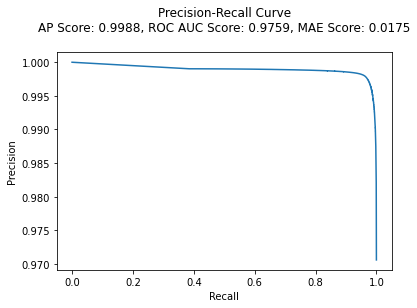

In [8]:
gt_arr_inverted = np.logical_not(gt_arr)
output_arr_inverted = 1 - output_arr
ap_score = average_precision_score(gt_arr_inverted, output_arr_inverted)
roc_auc_score1 = roc_auc_score(gt_arr_inverted, output_arr_inverted)
mae_score = mean_absolute_error(gt_arr_inverted, output_arr_inverted)
precision, recall, thresholds = precision_recall_curve(gt_arr_inverted, output_arr_inverted, pos_label=1)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
        #   f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
#           f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
         )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
print(gt_arr.shape, gt_list[0].shape)
ap_scores = []
f1_scores = []

for idx in range(len(gt_list)):
    gt_list[idx] = gt_list[idx].flatten()
    output_list[idx] = output_list[idx].flatten()
    gt_list[idx] = gt_list[idx].astype(np.uint8)
    print(gt_list[idx])
    p, r, thresh = precision_recall_curve(gt_list[idx], output_list[idx], pos_label=1)
    threshold_range = np.linspace(0, 1, 50)
    f1_scores_2 = []
    for t in threshold_range:
        output_binary = np.where(output_list[idx] >= t, 1, 0)
        f1 = f1_score(gt_list[idx], output_binary, pos_label=1)
        f1_scores_2.append(f1)


    # print(f"F1 score from sklearn {F1}")


        ap_score = average_precision_score(gt_list[idx], output_list[idx])
        roc_auc_score1 = roc_auc_score(gt_list[idx], output_list[idx])
        mae_score = mean_absolute_error(gt_list[idx], output_list[idx])
        plt.plot(r,p)
        plt.title('Precision-Recall Curve\n'
            f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
            f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
            f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.savefig(plot_dir+os.sep+f'{idx}.png')
        plt.clf()

In [ ]:
##U2NET-original

In [ ]:
model_dir = "/home/uas-dtu/Documents/U-2-Net-master/saved_models/u2net/u2net_bce_itr_206000_train_0.208217_tar_0.022493.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
plot_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/infered_plots/U2NET_og"
#dataset directory

dataset_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Datasets/deepcrack/"
prediction_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/Plotted_output/U2NET_og"

test_dataset = CrackDataset(
    img_path = dataset_dir + 'test_img/',
    mask_path = dataset_dir + 'test_lab/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )

test_dataloader = DataLoader(test_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [ ]:
from u2net import U2NET

model = U2NET()
model.load_state_dict(torch.load(model_dir))
model.cuda()
model.eval()

gt_list = []
output_list = []
gt_arr = np.ndarray([])
output_arr = np.ndarray([])

In [ ]:
bce_loss = nn.BCELoss(size_average=True) 
for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output,a,b,c,d,f,e = model(inputs_test)
    output = output[:,0,:,:]
    gt = data_test['mask'].view(1,288, 288)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)        

#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (288,288,1))
    gt_list.append(gt_np)
    gt_arr = np.append(gt_np, gt_list)
    output_np = np.reshape((output.cpu()).data.numpy(), (288,288,1))
    output_list.append(output_np)
    output_arr = np.append(output_np, output_list)
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
    axes[1].set_title(str(os.path.basename(model_dir)))
    axes[1].axis('off')
    axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
    plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
    plt.close()
    del output,a,b,c,d,f,e  

In [ ]:
gt_arr = gt_arr.astype(np.uint8)
precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
f1_scores_1 = (2 * recall * precision)/ (recall + precision + 1e-20)
# F1 = f1_score(gt_arr, output_arr, pos_label=1)
# best_threshold = thresholds[np.argmax(f1_score)]
# print(f"best threshold {best_threshold} best f1 score : {np.max(f1_scores)}")
threshold_range = np.linspace(0, 1, 100)
f1_scores_2 = []

for t in threshold_range:
    output_binary = np.where(output_arr >= t, 1, 0)

    f1 = f1_score(gt_arr, output_binary, pos_label=1)
    print(t,":",f1)
    f1_scores_2.append(f1)

print(f"F1 score from sklearn {max(f1_scores_2)}, max corresponding threshold is {threshold_range[np.argmax(f1_scores_2)]}")
print(len(gt_list))

In [ ]:
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
          f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
          f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(plot_dir+os.sep+'pr_curve.png')
plt.show()

In [ ]:
print(gt_arr.shape, gt_list[0].shape)
ap_scores = []
f1_scores = []

for idx in range(len(gt_list)):
    gt_list[idx] = gt_list[idx].flatten()
    output_list[idx] = output_list[idx].flatten()
    gt_list[idx] = gt_list[idx].astype(np.uint8)
    print(gt_list[idx])
    p, r, thresh = precision_recall_curve(gt_list[idx], output_list[idx], pos_label=1)
    threshold_range = np.linspace(0, 1, 50)
    f1_scores_2 = []
    for t in threshold_range:
        output_binary = np.where(output_list[idx] >= t, 1, 0)
        f1 = f1_score(gt_list[idx], output_binary, pos_label=1)
        f1_scores_2.append(f1)


    # print(f"F1 score from sklearn {F1}")


        ap_score = average_precision_score(gt_list[idx], output_list[idx])
        roc_auc_score1 = roc_auc_score(gt_list[idx], output_list[idx])
        mae_score = mean_absolute_error(gt_list[idx], output_list[idx])
        plt.plot(r,p)
        plt.title('Precision-Recall Curve\n'
            f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
            f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
            f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.savefig(plot_dir+os.sep+f'{idx}.png')
        plt.clf()

In [ ]:
#U2NET-dice

In [ ]:
model_dir = "/home/uas-dtu/Documents/U-2-Net-master/saved_models/u2net/dice_loss_last.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
plot_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/infered_plots/U2NET_diceog"
#dataset directory

dataset_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Datasets/deepcrack/"
prediction_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/Plotted_output/U2NET_diceog"

test_dataset = CrackDataset(
    img_path = dataset_dir + 'test_img/',
    mask_path = dataset_dir + 'test_lab/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )

test_dataloader = DataLoader(test_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [ ]:
from u2net import U2NET

model = U2NET()
model.load_state_dict(torch.load(model_dir))
model.cuda()
model.eval()

gt_list = []
output_list = []
gt_arr = np.ndarray([])
output_arr = np.ndarray([])

In [ ]:
bce_loss = nn.BCELoss(size_average=True) 
for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output,a,b,c,d,f,e = model(inputs_test)
    output = output[:,0,:,:]
    gt = data_test['mask'].view(1,288, 288)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)        

#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (288,288,1))
    gt_list.append(gt_np)
    gt_arr = np.append(gt_np, gt_list)
    output_np = np.reshape((output.cpu()).data.numpy(), (288,288,1))
    output_list.append(output_np)
    output_arr = np.append(output_np, output_list)
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
    axes[1].set_title(str(os.path.basename(model_dir)))
    axes[1].axis('off')
    axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
    plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
    plt.close()
    del output,a,b,c,d,f,e  

In [ ]:
gt_arr = gt_arr.astype(np.uint8)
precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
f1_scores_1 = (2 * recall * precision)/ (recall + precision + 1e-20)
# F1 = f1_score(gt_arr, output_arr, pos_label=1)
# best_threshold = thresholds[np.argmax(f1_score)]
# print(f"best threshold {best_threshold} best f1 score : {np.max(f1_scores)}")
threshold_range = np.linspace(0, 1, 100)
f1_scores_2 = []

for t in threshold_range:
    output_binary = np.where(output_arr >= t, 1, 0)

    f1 = f1_score(gt_arr, output_binary, pos_label=1)
    print(t,":",f1)
    f1_scores_2.append(f1)

print(f"F1 score from sklearn {max(f1_scores_2)}, max corresponding threshold is {threshold_range[np.argmax(f1_scores_2)]}")
print(len(gt_list))

In [ ]:
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
          f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
          f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(plot_dir+os.sep+'pr_curve.png')
plt.show()

In [ ]:
print(gt_arr.shape, gt_list[0].shape)
ap_scores = []
f1_scores = []

for idx in range(len(gt_list)):
    gt_list[idx] = gt_list[idx].flatten()
    output_list[idx] = output_list[idx].flatten()
    gt_list[idx] = gt_list[idx].astype(np.uint8)
    print(gt_list[idx])
    p, r, thresh = precision_recall_curve(gt_list[idx], output_list[idx], pos_label=1)
    threshold_range = np.linspace(0, 1, 50)
    f1_scores_2 = []
    for t in threshold_range:
        output_binary = np.where(output_list[idx] >= t, 1, 0)
        f1 = f1_score(gt_list[idx], output_binary, pos_label=1)
        f1_scores_2.append(f1)


    # print(f"F1 score from sklearn {F1}")


        ap_score = average_precision_score(gt_list[idx], output_list[idx])
        roc_auc_score1 = roc_auc_score(gt_list[idx], output_list[idx])
        mae_score = mean_absolute_error(gt_list[idx], output_list[idx])
        plt.plot(r,p)
        plt.title('Precision-Recall Curve\n'
            f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
            f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
            f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.savefig(plot_dir+os.sep+f'{idx}.png')
        plt.clf()

In [8]:
#UU2NET
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
import sys
import argparse
# import torch.optim as optim

import numpy as np
import os
from PIL import Image
import glob
from matplotlib import pyplot as plt
sys.path.append("../Models")
sys.path.append("../Models/DeepSegmentor")
from UU2NET.dataloader_uu3net import Rescale
from UU2NET.dataloader_uu3net import ToTensor
from UU2NET.dataloader_uu3net import CrackDataset
from u2net_withoutd9 import UU2NET

import cv2
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchmetrics

from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score,  average_precision_score, roc_auc_score, mean_absolute_error

In [9]:
model_dir = "/home/uas-dtu/Documents/U2NET-main/saved_models/uu2net_original_kaggle_dataset/uu2net_bce_itr_144000_train_0.000396_.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
plot_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/infered_plots/UU2NET_self_split"
#dataset directory

dataset_dir = "/home/uas-dtu/Documents/U2NET-main/split_dataset/val/"
train_dir = "/home/uas-dtu/Documents/U2NET-main/split_dataset/train/"
prediction_dir = "/home/uas-dtu/Documents/Chirag/CrackDetection/Inference/Plotted_output/U2NET_self_split"

test_dataset = CrackDataset(
    img_path = dataset_dir + 'images/',
    mask_path = dataset_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
train_dataset = CrackDataset(
    img_path = train_dir + 'images/',
    mask_path = train_dir + 'masks/',
    transforms = transforms.Compose([Rescale(288),ToTensor(flag = 0)])
    )
test_dataloader = DataLoader(test_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)
train_dataloader = DataLoader(train_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [10]:
model = UU2NET()
model.load_state_dict(torch.load(model_dir))
model.eval()

gt_list = []
output_list = []
gt_arr = np.ndarray([])
output_arr = np.ndarray([])

bce_loss = nn.BCELoss(size_average=True)

/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [11]:
for i_test, data_test in enumerate(test_dataloader):
    inputs_test = data_test['image']
    if device == "cuda":
        inputs_test = inputs_test.type(torch.FloatTensor).cuda()
    else:
        inputs_test = inputs_test.type(torch.FloatTensor)
    output = model(inputs_test)
    output = output[:,0,:,:]
    gt = data_test['mask'].view(1,288, 288)
    if device == "cuda":
        gt = gt.type(torch.FloatTensor).cuda()
    else:
        gt = gt.type(torch.FloatTensor)        

#outputs and ground truth
    gt_np = np.reshape((gt.cpu()).data.numpy(), (288,288,1))
    gt_list.append(gt_np)
    gt_arr = np.append(gt_np, gt_list)
    output_np = np.reshape((output.cpu()).data.numpy(), (288,288,1))
    output_list.append(output_np)
    output_arr = np.append(output_np, output_list)
    print(np.max(gt_np), ":max of ground truth ", np.min(gt_np), ":min of ground truth")
    print(np.max(output_np), ":max of ops ", np.min(output_np), ":min of ops")

    loss1 = bce_loss(output, gt)
    # fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    # axes[0].imshow(gt_np, cmap = 'gray',vmin=0, vmax=1)
    # axes[0].set_title('Ground Truth')
    # axes[0].axis('off')
    # axes[1].imshow(output_np, cmap = 'gray',vmin=0, vmax=1)
    # axes[1].set_title(str(os.path.basename(model_dir)))
    # axes[1].axis('off')
    # axes[1].text(0.5, -0.1, f'LOSS:{loss1}', transform=axes[1].transAxes, ha='center')
    # plt.savefig(prediction_dir+os.sep+str(i_test)+'.png', dpi=300, bbox_inches='tight')
    # plt.close()
    del output
    if i_test == 237:
        break

/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/uas-dtu/.local/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1.0 :max of ground truth  0.0 :min of ground truth
0.9859505 :max of ops  2.8777173e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.95404494 :max of ops  7.59251e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9720452 :max of ops  8.5208385e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.99381614 :max of ops  1.2304852e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9348227 :max of ops  1.8194628e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9480908 :max of ops  6.964302e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.99501425 :max of ops  7.193875e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9414535 :max of ops  8.2202203e-13 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.924712 :max of ops  8.617942e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.93486625 :max of ops  3.3453604e-12 :min of ops
1.

1.0 :max of ground truth  0.0 :min of ground truth
0.985911 :max of ops  1.869344e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9719526 :max of ops  7.510064e-13 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.99186534 :max of ops  5.2437547e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9217296 :max of ops  2.9074325e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9986858 :max of ops  9.323648e-14 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.99537766 :max of ops  2.7829076e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9999945 :max of ops  1.7244919e-13 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9639208 :max of ops  1.6077788e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9993716 :max of ops  1.1033238e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.98074234 :max of ops  3.1219441e-12 :min of ops
1

1.0 :max of ground truth  0.0 :min of ground truth
0.9932761 :max of ops  9.161731e-10 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9998362 :max of ops  9.9209745e-11 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.98899347 :max of ops  1.4475669e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.98776335 :max of ops  3.9733157e-14 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.88386565 :max of ops  5.403586e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9973579 :max of ops  4.3930675e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9999882 :max of ops  3.4247197e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.97985464 :max of ops  5.05397e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9747595 :max of ops  3.202618e-12 :min of ops
1.0 :max of ground truth  0.0 :min of ground truth
0.9963566 :max of ops  4.3370993e-10 :min of ops
1

Average Precision Score: 0.9296197400656755
ROC AUC Score: 0.9963705132484151
MAE Score: 0.02037627063691616


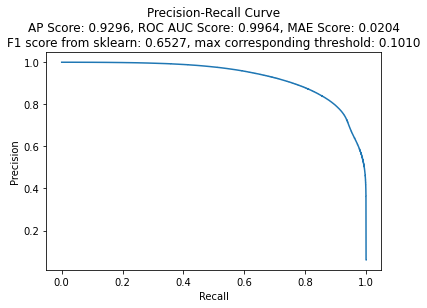

In [13]:
gt_arr = gt_arr.astype(np.uint8)
precision, recall, thresholds = precision_recall_curve(gt_arr, output_arr, pos_label=1)
ap_score = average_precision_score(gt_arr, output_arr)
roc_auc_score1 = roc_auc_score(gt_arr, output_arr)
mae_score = mean_absolute_error(gt_arr, output_arr)
print(f"Average Precision Score: {ap_score}")
print(f"ROC AUC Score: {roc_auc_score1}")
print(f"MAE Score: {mae_score}")

plt.plot(recall,precision)
plt.title('Precision-Recall Curve\n'
          f"AP Score: {ap_score:.4f}, ROC AUC Score: {roc_auc_score1:.4f}, MAE Score: {mae_score:.4f}\n"
          f"F1 score from sklearn: {max(f1_scores_2):.4f}, "
          f"max corresponding threshold: {threshold_range[np.argmax(f1_scores_2)]:.4f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(plot_dir+os.sep+'pr_curve.png')
plt.show()